In [2]:
from collections import Counter
from pprint import pprint
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import linalg as LA

from sklearn.manifold import TSNE

In [3]:
FILE_NAME = '128_128_relu_relu_20_20_adjacentTF_1e-4'
DATA_DIR = Path("../../data/")

we first explore the original graph (before embedding)

In [4]:
data_processor = Preprocess()
df = data_processor.raw2train(DATA_DIR)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [6]:
emb_df = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)
emb_df = emb_df.drop(['type'], axis='columns')

# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
# edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

Running KNN...
KNN completed!
Creating edgelist...


source  target  distance
0  MCHR1   TFPI2  0.364406
1  MCHR1     CLC  0.414372
2  MCHR1  ZBTB7C  0.465135
3  MCHR1    MYLK  0.493924
4  MCHR1    EMP2  0.496718

In [7]:
# G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target']], 'source', 'target', create_using=nx.Graph)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 706598
Average degree:  76.0887


In [8]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G, resolution=1.5, random_state=0)
max(set(partition.values()))

7

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [9]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({6: 69})
Cluster of GM:  Counter({6: 69})
Cluster of normal gene:  Counter({4: 7193, 2: 4726, 1: 2377, 0: 2368, 5: 1402, 3: 197, 7: 172})


In [10]:
mean_clusters = emb_df.groupby('class').mean()

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters)

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed



Running TSNE...
Mapping names to classes...


0          1  type
MCHR1   45.581913  -9.105925     0
PSMD9  -31.076508  15.087100     0
CRIP1  -41.611458 -13.590816     0
GIMAP4 -41.402325 -48.091457     0
GATM     8.679531   7.368512     0
...           ...        ...   ...
3       52.176712   7.041439    10
4      -31.846119  -7.943364    10
5      -27.716326 -53.065617    10
6      -41.790756  47.863285    10
7       68.196281   1.287186    10

[18581 rows x 3 columns]

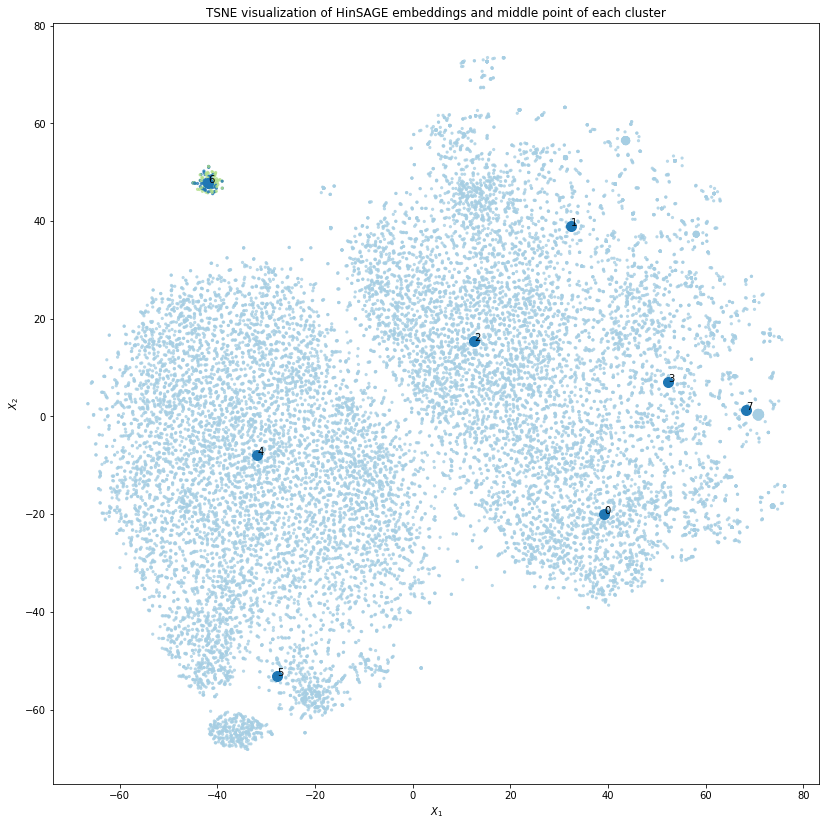

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)

# Annotate ID of each cluster
n_clusters = max(set(partition.values())) + 1
for i in range(n_clusters):
    ax.annotate(str(i), (emb_transformed[emb_transformed['type'] == 10].loc[i][0]+.05, emb_transformed[emb_transformed['type'] == 10].loc[i][1]+.05))
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings and middle point of each cluster")

# plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
plt.show()

We could also color the graph by the class of each node

In [16]:
# _idx = list(emb_df.columns)[:-1]

# print('Running TSNE...')
# trans = TSNE(n_components=2, random_state=0)
# emb_transformed = pd.DataFrame(trans.fit_transform(emb_df[_idx]), index=emb_df.index)
# emb_transformed['class'] = emb_df['class']

# fig, ax = plt.subplots(figsize=(14, 14))
# ax.scatter(
#     emb_transformed[0],
#     emb_transformed[1],
#     c=emb_transformed["class"],
#     # cmap="inferno",
#     alpha=alpha,
#     s=5
# )

# ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
# plt.title(f"TSNE visualization of HinSAGE embeddings colored by class")

# # plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
# plt.show()

We could calculate the distance between clusters, the distance is defined as how many hops are needed from one node to another

In [13]:
gms = list(gm_cluster_df.index)
ks = list(k_cluster_df.index)
genes = list(gene_cluster_df.index)

print(len(genes))
cluster_df

18435


class  is_tf
MCHR1         0      0
PSMD9         4      0
CRIP1         4      0
GIMAP4        5      0
GATM          2      0
...         ...    ...
ERCC5         4      0
MARVELD1      0      0
YTHDC2        4      0
SRC           4      0
C1GALT1       2      0

[18573 rows x 2 columns]

In [14]:
shortest_paths = {}
tfs = gms + ks

shortest_paths_df = pd.DataFrame(index=genes, columns=tfs, dtype=np.int16)

for tf in tfs:
    shortest_paths[tf] = nx.shortest_path_length(G_original, source=tf)


In [15]:
shortest_paths_df = pd.DataFrame(shortest_paths)
shortest_paths_df = shortest_paths_df[~shortest_paths_df.index.isin(tfs)]
shortest_paths_df.sort_index(inplace=True)

shortest_paths_cluster = cluster_df[cluster_df.index.isin(shortest_paths_df.index)].sort_index()
# shortest_paths_cluster
shortest_paths_df['cluster'] = shortest_paths_cluster['class']

# Mode
# shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').agg(lambda x:x.value_counts().index[0]).to_frame()

# Mean
shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').mean().to_frame().sort_values([0])

0
cluster          
4        1.767596
2        2.266041
5        2.274073
0        2.776057
1        2.835882
3        2.948724
7        2.970172

In [28]:
shortest_paths_df.columns 

EZH2_gm  TARDBP_gm  E2F4_gm  JUND_gm  ATF3_gm  SPI1_gm  ELK1_gm  \
A1BG                3          3        3        3        3        3        3   
A1CF                4          2        2        3        4        2        2   
A2M                 3          3        3        3        3        1        3   
A2ML1               3          3        3        3        3        3        3   
A3GALT2             3          3        3        3        3        3        3   
...               ...        ...      ...      ...      ...      ...      ...   
ZZEF1               3          1        3        1        1        1        1   
ZZZ3                3          1        3        3        1        3        3   
eIF2A               3          2        3        2        3        2        2   
hsa-mir-1199        3          3        3        3        3        3        3   
hsa-mir-150         3          3        3        3        3        1        3   

              HDGF_gm  BHLHE40_gm  NFYB_gm  ...  ZBED1_k  POLR3G_k  SUZ12_k  \
A1BG                1           1        3  ...        3         3        3   
A1CF                2           2        2  ...        3         4        3   
A2M                 2           3        3  ...        3         3        3   
A2ML1               3           3        3  ...        3         3        3   
A3GALT2             3           3        3  ...        3         3        3   
...               ...         ...      ...  ...      ...       ...      ...   
ZZEF1               1           1        2  ...        2         3        3   
ZZZ3                1           1        3  ...        1         3        3   
eIF2A               2           2        2  ...        2         3        3   
hsa-mir-1199        1           1        3  ...        3         3        3   
hsa-mir-150         3           3        3  ...        3         3        3   

              ATF3_k  NRF1_k  MAX_k  ETS1_k  NFYB_k  SMAD5_k  cluster  
A1BG               3       1      1       3       3        3        5  
A1CF               3       2      2       2       3        2        1  
A2M                3       3      2       3       2        3        1  
A2ML1              3       3      1       3       3        3        0  
A3GALT2            3       1      3       3       3        3        0  
...              ...     ...    ...     ...     ...      ...      ...  
ZZEF1              1       1      1       1       2        1        2  
ZZZ3               1       1      1       1       3        1        5  
eIF2A              2       2      2       2       2        2        3  
hsa-mir-1199       1       1      1       3       3        3        5  
hsa-mir-150        3       3      3       3       3        1        5  

[18427 rows x 139 columns]